In [1]:
import pandas as pd
import os
import numpy as np

# data- preprocessing

In [7]:
# Define the directory containing your CSV files
# place the link to the text file here
directory = '/Users/martinso/Desktop/LST/HS-KI/Year 2/research trend/text'

data = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Initialize a list to store each row's text as a list of words
        texts = []

        # Loop through each row in the DataFrame
        for index, row in df.iterrows():
            # Check for NaN and add text to the list after splitting into words
            if pd.notna(row['Text']):
                # Split the text into words and append the list of words
                texts.append(row['Text'].split())

        # Append the filename (without extension) and the list of texts to the data list
        data.append([os.path.splitext(filename)[0], texts])

# Create a DataFrame from the collected data
df_combined = pd.DataFrame(data, columns=['File Name', 'Text Data'])

# Define the path for the output Excel file
#output_file_path = os.path.join(directory, 'aggregated_texts_by-sentence.xlsx')

# Save the DataFrame to Excel
#df_combined.to_excel(output_file_path, index=False)


#print("All files have been processed and output to 'aggregated_texts.csv'.")

FileNotFoundError: [Errno 2] No such file or directory: '../text'

In [7]:
df_combined.head()

,File Name,Text Data
0,369_Transcript,"[[okay, awesome, thank, you], [are, you, okay,..."
1,423_Transcript,"[[okay], [and, please], [yes], [feeling, well]..."
2,436_Transcript,"[[that, was, big], [yes], [I'm, doing, fine], ..."
3,318_Transcript,"[[all, right], [okay], [oh, actually, before, ..."
4,447_Transcript,"[[yeah, that's, perfectly, fine], [I'm, feelin..."


In [8]:
df_combined.rename(columns={'File Name': 'Name'}, inplace=True)
df_combined['Name'] = df_combined['Name'].str.replace('_Transcript', '')
df_combined['Name']=df_combined['Name'].astype(int)

In [9]:
df_combined.head()

,Name,Text Data
0,369,"[[okay, awesome, thank, you], [are, you, okay,..."
1,423,"[[okay], [and, please], [yes], [feeling, well]..."
2,436,"[[that, was, big], [yes], [I'm, doing, fine], ..."
3,318,"[[all, right], [okay], [oh, actually, before, ..."
4,447,"[[yeah, that's, perfectly, fine], [I'm, feelin..."


In [3]:
df = pd.read_csv('label_daic_extend - label_daic_extend.csv')
df.head()
df_filtered = df[['Participant_ID','depression']]

In [11]:
depression_map = df_filtered.set_index('Participant_ID')['depression']

df_combined['depression'] = df_combined['Name'].map(depression_map)




In [12]:
df_combined

,Name,Text Data,depression
0,369,"[[okay, awesome, thank, you], [are, you, okay,...",0
1,423,"[[okay], [and, please], [yes], [feeling, well]...",0
2,436,"[[that, was, big], [yes], [I'm, doing, fine], ...",0
3,318,"[[all, right], [okay], [oh, actually, before, ...",0
4,447,"[[yeah, that's, perfectly, fine], [I'm, feelin...",0
...,...,...,...
214,484,"[[okay], [yes], [I'm, doing, well], [I, was, b...",0
215,491,"[[do, I, still, have, to, put, my, cat], [okay...",0
216,340,"[[bring, up, a, virtual, human, that, you're, ...",0
217,355,"[[yes], [alright], [I, was, born, in, Los, Ang...",1


Here i try to calculate the percentage of interviewee with depression

In [13]:
neg, pos = df_combined['depression'].value_counts()

percentage = pos *100 / (neg + pos)
print(f"the percentage of patient with depression is: {percentage}%")


the percentage of patient with depression is: 29.680365296803654%


It seem like there is a imbalanced class in the data, we should take account of that when we try to build up the ML model.

In [14]:
df_combined['lengths of speech'] = df_combined['Text Data'].apply(lambda x: [len(lst) for lst in x])
# Count the number of inner lists in each cell and create a new column
df_combined['frequency of speech'] = df_combined['Text Data'].apply(len)

In [15]:
df_combined.head()

,Name,Text Data,depression,lengths of speech,frequency of speech
0,369,"[[okay, awesome, thank, you], [are, you, okay,...",0,"[4, 6, 12, 1, 20, 6, 65, 1, 78, 51, 14, 47, 1,...",61
1,423,"[[okay], [and, please], [yes], [feeling, well]...",0,"[1, 2, 1, 2, 12, 1, 2, 4, 2, 3, 3, 6, 10, 9, 1...",112
2,436,"[[that, was, big], [yes], [I'm, doing, fine], ...",0,"[3, 1, 3, 1, 7, 11, 24, 14, 29, 14, 10, 13, 5,...",56
3,318,"[[all, right], [okay], [oh, actually, before, ...",0,"[2, 1, 14, 3, 1, 3, 3, 9, 5, 5, 11, 15, 1, 1, ...",48
4,447,"[[yeah, that's, perfectly, fine], [I'm, feelin...",0,"[4, 11, 7, 17, 12, 14, 14, 15, 85, 1, 17, 6, 3...",61


Here i try to calculate the frequency of interviewees speak in the interview and the length of their sppech per times

In [16]:
def calculate_mean(lengths):
    if len(lengths) > 0:  # Check if the list is not empty to avoid division by zero
        return sum(lengths) / len(lengths)
    else:
        return None
    
df_combined['mean length of speech'] = df_combined['lengths of speech'].apply(calculate_mean)

In [17]:
mean_values = df_combined.groupby('depression')[['frequency of speech', 'mean length of speech']].mean()

print(mean_values)

            frequency of speech  mean length of speech
depression                                            
0                     88.642857              15.954897
1                    105.553846              14.008058


There is a significant difference in frequency of speech

In [18]:
def flatten_text(row):
    # This will flatten the list of lists found in 'Text Data' for a row
    flattened = [item for sublist in row['Text Data'] for item in sublist]
    return flattened  # Returning the flattened list directly

# Apply this function and create a new column
df_combined['flattened text'] = df_combined.apply(flatten_text, axis=1)


In [19]:
df_combined.head()

,Name,Text Data,depression,lengths of speech,frequency of speech,mean length of speech,flattened text
0,369,"[[okay, awesome, thank, you], [are, you, okay,...",0,"[4, 6, 12, 1, 20, 6, 65, 1, 78, 51, 14, 47, 1,...",61,34.213115,"[okay, awesome, thank, you, are, you, okay, wi..."
1,423,"[[okay], [and, please], [yes], [feeling, well]...",0,"[1, 2, 1, 2, 12, 1, 2, 4, 2, 3, 3, 6, 10, 9, 1...",112,9.732143,"[okay, and, please, yes, feeling, well, where,..."
2,436,"[[that, was, big], [yes], [I'm, doing, fine], ...",0,"[3, 1, 3, 1, 7, 11, 24, 14, 29, 14, 10, 13, 5,...",56,23.250000,"[that, was, big, yes, I'm, doing, fine, Mexico..."
3,318,"[[all, right], [okay], [oh, actually, before, ...",0,"[2, 1, 14, 3, 1, 3, 3, 9, 5, 5, 11, 15, 1, 1, ...",48,14.062500,"[all, right, okay, oh, actually, before, that,..."
4,447,"[[yeah, that's, perfectly, fine], [I'm, feelin...",0,"[4, 11, 7, 17, 12, 14, 14, 15, 85, 1, 17, 6, 3...",61,20.590164,"[yeah, that's, perfectly, fine, I'm, feeling, ..."


In [20]:
def mean_word_length(words):
    if not words:  # Check if the list is empty
        return 0
    return sum(len(word) for word in words) / len(words)

# Apply the function to calculate the mean word length for each row
df_combined['mean_word_length'] = df_combined['flattened text'].apply(mean_word_length)

In [21]:
df_combined.head()

,Name,Text Data,depression,lengths of speech,frequency of speech,mean length of speech,flattened text,mean_word_length
0,369,"[[okay, awesome, thank, you], [are, you, okay,...",0,"[4, 6, 12, 1, 20, 6, 65, 1, 78, 51, 14, 47, 1,...",61,34.213115,"[okay, awesome, thank, you, are, you, okay, wi...",3.849545
1,423,"[[okay], [and, please], [yes], [feeling, well]...",0,"[1, 2, 1, 2, 12, 1, 2, 4, 2, 3, 3, 6, 10, 9, 1...",112,9.732143,"[okay, and, please, yes, feeling, well, where,...",4.326606
2,436,"[[that, was, big], [yes], [I'm, doing, fine], ...",0,"[3, 1, 3, 1, 7, 11, 24, 14, 29, 14, 10, 13, 5,...",56,23.250000,"[that, was, big, yes, I'm, doing, fine, Mexico...",4.010753
3,318,"[[all, right], [okay], [oh, actually, before, ...",0,"[2, 1, 14, 3, 1, 3, 3, 9, 5, 5, 11, 15, 1, 1, ...",48,14.062500,"[all, right, okay, oh, actually, before, that,...",3.961481
4,447,"[[yeah, that's, perfectly, fine], [I'm, feelin...",0,"[4, 11, 7, 17, 12, 14, 14, 15, 85, 1, 17, 6, 3...",61,20.590164,"[yeah, that's, perfectly, fine, I'm, feeling, ...",4.042197


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_combined is already defined and includes the necessary columns
# Convert 'depression' to a categorical type if it's not already
df_combined['depression'] = df_combined['depression'].astype('category')

def visualize(col):
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # figsize can be adjusted based on your display preferences

    # First plot: Boxplot
    sns.boxplot(ax=axes[0], y=df_combined[col], x=df_combined['depression'],hue=df_combined['depression'])
    axes[0].set_ylabel(col, labelpad=12.5)
    axes[0].set_xlabel('Depression')
    
    # Second plot: KDE Plot
    sns.kdeplot(ax=axes[1], x=df_combined[col], hue=df_combined['depression'], common_norm=False)
    plt.legend(title='Depression', labels=df_combined['depression'].cat.categories)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

# Example usage
# visualize('mean_word_length')  # replace 'mean_word_length' with the actual column name you want to plot


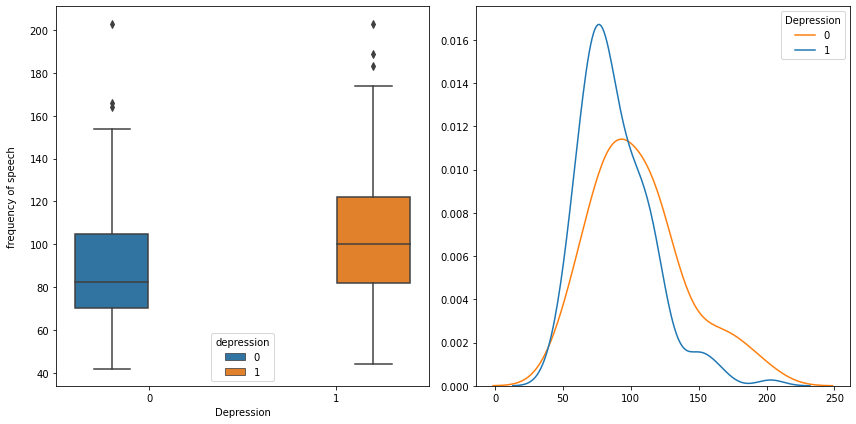

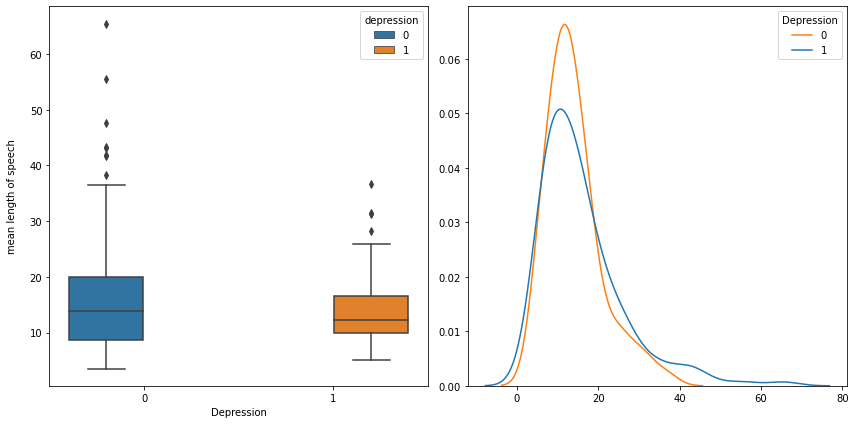

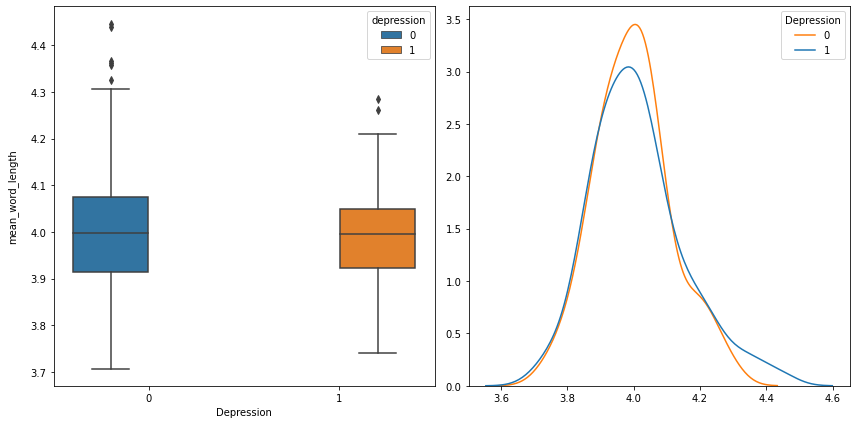

In [23]:
features = ['frequency of speech','mean length of speech','mean_word_length']
for feature in features:
    visualize(feature)

Further analysis of the speech of interviewees, it seem like there is a higher chance for interviewee with depression to have a shorter pseech per times.

In the following I will try to normalise the text, and shopw the importance of normalisation 

In [37]:
import pandas as pd
import re

def find_apostrophe_words(text_list):
    # Regex pattern to find words with apostrophes
    pattern = r"\b\w+'(?:\w+|t)\b|\B'\w+\b"
    apo_terms = []  # Initialize an empty list to collect all terms
    for item in text_list:
        # Find all matches and extend them to the apo_terms list
        apo_terms.extend(re.findall(pattern, item))
    return apo_terms

# Assuming df_combined['flattened text'] contains lists of strings
all_words_with_apostrophes = [word for text in df_combined['flattened text'].dropna() for word in find_apostrophe_words(text)]

# Convert list to a set to remove duplicates, then back to list to print or use further
unique_words_with_apostrophes = list(set(all_words_with_apostrophes))

# Print unique words
print(unique_words_with_apostrophes)

["many's", "you'll", "Joey's", "Alzheimer's", "i've", "wife's", "wouldn't", "nurse's", "What's", "how'd", "boyfriend's", "master's", "Asperger's", "Chili's", "Museum's", "she'd", "that'll", "dog's", "Happy's", "girl's", "it's", "Father's", "people's", "thing's", "everyone's", "Bennigan's", "Bill's", "LA's", "God's", "I'm", "grandmother's", "y'alls", "Brett's", "Simon's", "husband's", "Lowe's", "castaneda's", "body's", "what's", "didn't", "area's", "friend's", "McDonald's", "he's", "momma's", "Square's", "Wendy's", "Bachelor's", "nothing's", "Eddie's", "ma'am", "somebody's", "cat's", "they've", "everybody's", "Scoma's", "Lord's", "who's", "Sophie's", "neighborhood's", "I've", "Esmeralda's", "we're", "stepfather's", "dad's", "That's", "Frank's", "Year's", "Workman's", "you'd", "you're", "bachelor's", "hasn't", "she's", "that's", "He's", "family's", "kid's", "uncle's", "associate's", "something's", "mother's", "Daughter's", "sister's", "woman's", "mama's", "mine's", "night's", "Tennessee'

In [34]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

def tokenize_and_flatten(text_list):
    tokenized_list = [tokenizer.tokenize(word) for word in text_list]
    # Flatten the list of lists into a single list
    flat_list = [item for sublist in tokenized_list for item in sublist]
    return flat_list

# Apply the tokenizer to the 'flattened text' column and store the results in a new column
df_combined['tokenized_text'] = df_combined['flattened text'].apply(tokenize_and_flatten)



In [35]:
df_combined.head()

,Name,Text Data,depression,lengths of speech,frequency of speech,mean length of speech,flattened text,mean_word_length,tokenized_text
0,369,"[[okay, awesome, thank, you], [are, you, okay,...",0,"[4, 6, 12, 1, 20, 6, 65, 1, 78, 51, 14, 47, 1,...",61,34.213115,"[okay, awesome, thank, you, are, you, okay, wi...",3.849545,"[okay, awesome, thank, you, are, you, okay, wi..."
1,423,"[[okay], [and, please], [yes], [feeling, well]...",0,"[1, 2, 1, 2, 12, 1, 2, 4, 2, 3, 3, 6, 10, 9, 1...",112,9.732143,"[okay, and, please, yes, feeling, well, where,...",4.326606,"[okay, and, please, yes, feeling, well, where,..."
2,436,"[[that, was, big], [yes], [I'm, doing, fine], ...",0,"[3, 1, 3, 1, 7, 11, 24, 14, 29, 14, 10, 13, 5,...",56,23.250000,"[that, was, big, yes, I'm, doing, fine, Mexico...",4.010753,"[that, was, big, yes, I, 'm, doing, fine, Mexi..."
3,318,"[[all, right], [okay], [oh, actually, before, ...",0,"[2, 1, 14, 3, 1, 3, 3, 9, 5, 5, 11, 15, 1, 1, ...",48,14.062500,"[all, right, okay, oh, actually, before, that,...",3.961481,"[all, right, okay, oh, actually, before, that,..."
4,447,"[[yeah, that's, perfectly, fine], [I'm, feelin...",0,"[4, 11, 7, 17, 12, 14, 14, 15, 85, 1, 17, 6, 3...",61,20.590164,"[yeah, that's, perfectly, fine, I'm, feeling, ...",4.042197,"[yeah, that, 's, perfectly, fine, I, 'm, feeli..."


In [38]:
all_words_with_apostrophes = [word for text in df_combined['tokenized_text'].dropna() for word in find_apostrophe_words(text)]

# Convert list to a set to remove duplicates, then back to list to print or use further
unique_words_with_apostrophes = list(set(all_words_with_apostrophes))

# Print unique words
print(unique_words_with_apostrophes)

["'s", "n't", "'m", "'d", "'ve", "s'more", "Hold'em", "y'alls", "I'ma", "'ll", "ma'am", "'re", "y'all"]


In [26]:
import nltk
from nltk.corpus import stopwords
import re


stop=set(stopwords.words('english'))

In [42]:
contractions_dict = {
    "'s": "is",     # depending on context, can also be 'has' or possessive marker
    "n't": "not",
    "'m": "am",
    "'d": "would",  # can also mean "had" depending on context
    "'ve": "have",
    "s'more": "some more" ,
    "Hold'em": "hold them",
    "y'alls": "you alls",
    "I'ma": "I am going to",
    "'ll": "will",
    "ma'am": "madam",
    "'re": "are",
    "y'all": "you all"
}

import pandas as pd

# Assume 'df_combined' is your DataFrame and contractions_dict is defined as provided

def expand_contractions(tokens, contractions_dict):
    expanded_tokens = []
    for token in tokens:
        # Check each token if it's a contraction
        if token.lower() in contractions_dict:
            # If it is, replace it with the expanded form
            expanded_tokens.extend(contractions_dict[token.lower()].split())
        else:
            # Otherwise, keep the token as is
            expanded_tokens.append(token)
    return expanded_tokens

# Apply this function to each row in the tokenized_text column
df_combined['expanded_text'] = df_combined['tokenized_text'].apply(lambda x: expand_contractions(x, contractions_dict))
df_combined['expanded_text']  =df_combined['expanded_text'].apply(lambda x: ' '.join(x))
df_combined['expanded_text'] = df_combined['expanded_text'].apply(lambda x: x.split())



In [43]:
df_combined.head()

,Name,Text Data,depression,lengths of speech,frequency of speech,mean length of speech,flattened text,mean_word_length,tokenized_text,expanded_text
0,369,"[[okay, awesome, thank, you], [are, you, okay,...",0,"[4, 6, 12, 1, 20, 6, 65, 1, 78, 51, 14, 47, 1,...",61,34.213115,"[okay, awesome, thank, you, are, you, okay, wi...",3.849545,"[okay, awesome, thank, you, are, you, okay, wi...","[okay, awesome, thank, you, are, you, okay, wi..."
1,423,"[[okay], [and, please], [yes], [feeling, well]...",0,"[1, 2, 1, 2, 12, 1, 2, 4, 2, 3, 3, 6, 10, 9, 1...",112,9.732143,"[okay, and, please, yes, feeling, well, where,...",4.326606,"[okay, and, please, yes, feeling, well, where,...","[okay, and, please, yes, feeling, well, where,..."
2,436,"[[that, was, big], [yes], [I'm, doing, fine], ...",0,"[3, 1, 3, 1, 7, 11, 24, 14, 29, 14, 10, 13, 5,...",56,23.250000,"[that, was, big, yes, I'm, doing, fine, Mexico...",4.010753,"[that, was, big, yes, I, 'm, doing, fine, Mexi...","[that, was, big, yes, I, am, doing, fine, Mexi..."
3,318,"[[all, right], [okay], [oh, actually, before, ...",0,"[2, 1, 14, 3, 1, 3, 3, 9, 5, 5, 11, 15, 1, 1, ...",48,14.062500,"[all, right, okay, oh, actually, before, that,...",3.961481,"[all, right, okay, oh, actually, before, that,...","[all, right, okay, oh, actually, before, that,..."
4,447,"[[yeah, that's, perfectly, fine], [I'm, feelin...",0,"[4, 11, 7, 17, 12, 14, 14, 15, 85, 1, 17, 6, 3...",61,20.590164,"[yeah, that's, perfectly, fine, I'm, feeling, ...",4.042197,"[yeah, that, 's, perfectly, fine, I, 'm, feeli...","[yeah, that, is, perfectly, fine, I, am, feeli..."


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


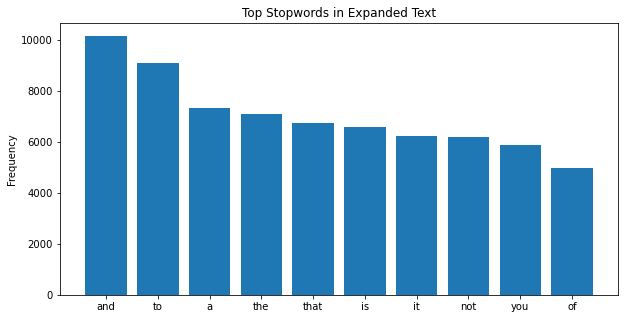

In [53]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
import pandas as pd
import nltk

nltk.download('stopwords')

# Set up stopwords
stop = set(stopwords.words('english'))

# Assuming 'expanded_text' is already a list of words per document
# If 'expanded_text' is not a list of words, uncomment the following line:
# df_combined['expanded_text'] = df_combined['expanded_text'].apply(lambda x: x.split())

# Flatten the list of lists into a single list of words
corpus = [word for sublist in df_combined['expanded_text'] for word in sublist]

# Dictionary to count occurrences of each stopword
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

# Sorting the dictionary by frequency of stopwords and getting the top 10
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = zip(*top)  # Unpack the top words and their counts

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.title('Top Stopwords in Expanded Text')
plt.ylabel('Frequency')
plt.show()



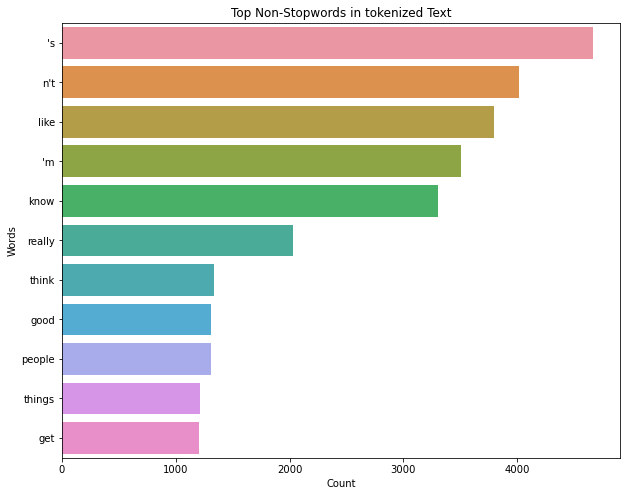

In [56]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    # Flatten the list of lists into a single list if necessary
    # Assuming 'text' is a list of lists of words; if not, comment out the next two lines
    text = [word for sublist in text for word in sublist]
    
    counter = Counter(text)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:40]:
        if word.lower() not in stop:  # Check against stopwords using lowercased words
            x.append(word)
            y.append(count)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=y, y=x)
    plt.title('Top Non-Stopwords in tokenized Text')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.show()

# Apply the function to the 'expanded_text' column
plot_top_non_stopwords_barchart(df_combined['tokenized_text'])


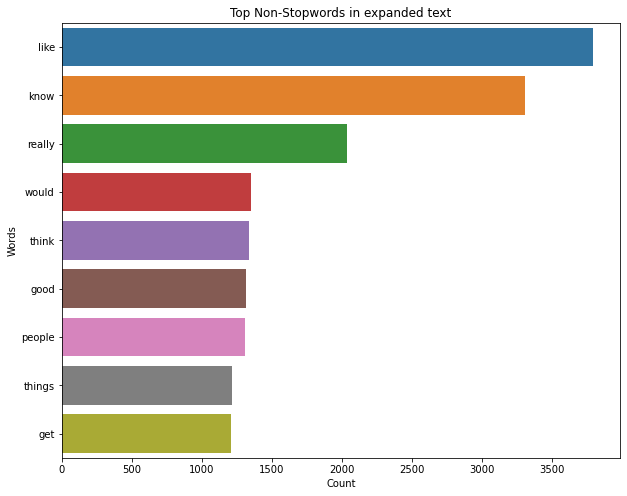

In [57]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    # Flatten the list of lists into a single list if necessary
    # Assuming 'text' is a list of lists of words; if not, comment out the next two lines
    text = [word for sublist in text for word in sublist]
    
    counter = Counter(text)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:40]:
        if word.lower() not in stop:  # Check against stopwords using lowercased words
            x.append(word)
            y.append(count)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=y, y=x)
    plt.title('Top Non-Stopwords in expanded text')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.show()

plot_top_non_stopwords_barchart(df_combined['expanded_text'])
    

# sentiment analysis

1. rule-based 
https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair

In [54]:
import nltk
nltk.download('vader_lexicon')

import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Function to apply VADER and return the compound score
def apply_vader(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

# Assuming 'expanded_text' column is a list of words, join them into a single string per row
df_combined['expanded_text_str'] = df_combined['expanded_text'].apply(lambda x: ' '.join(x))

# Apply the VADER analysis on the joined text
df_combined['vader_sentiment'] = df_combined['expanded_text_str'].apply(apply_vader)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/martinso/nltk_data...


                                     expanded_text_str  vader_sentiment
0    okay awesome thank you are you okay with this ...           1.0000
1    okay and please yes feeling well where are you...           0.9991
2    that was big yes I am doing fine Mexico when I...           0.9988
3    all right okay oh actually before that one thi...           0.9995
4    yeah that is perfectly fine I am feeling great...           0.9995
..                                                 ...              ...
214  okay yes I am doing well I was born in Oakland...           0.9995
215  do I still have to put my cat okay yes how ove...           0.9991
216  bring up a virtual human that you are going to...           0.9970
217  yes alright I was born in Los Angeles Californ...           0.2342
218  go ahead and start a camcorder recording and t...           0.9999

[219 rows x 2 columns]


In [55]:
mean_vader_sentiment = df_combined.groupby('depression')[['vader_sentiment']].mean()

print(mean_vader_sentiment)

            vader_sentiment
depression                 
0                  0.971945
1                  0.920295


2. embedding model 

In [63]:
import flair
from flair.models import TextClassifier
from flair.data import Sentence

# Load the sentiment classifier
classifier = TextClassifier.load('en-sentiment')

def flair_sentiment(text):
    # Make sure text is a string
    sentence = Sentence(text)
    classifier.predict(sentence)
    # Flair outputs labels with additional information, extracting sentiment and score
    return sentence.labels[0].value, sentence.labels[0].score

df_combined['flair_sentiment'], df_combined['flair_score'] = zip(*df_combined['expanded_text_str'].apply(flair_sentiment))

# View the DataFrame to see the added sentiment analysis results
print(df_combined[['expanded_text_str', 'flair_sentiment', 'flair_score']])

NameError: name '_C' is not defined

In [65]:
import torch
print(torch.__version__)

NameError: name '_C' is not defined